In [1]:
# Import the pandas library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from xgboost import XGBRegressor
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib

In [2]:
# Load the scraped data into a DataFrame
df = pd.read_csv('cardiff_properties_enriched.csv')

In [3]:
# General inspection of the data
print("--- Data Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  1050 non-null   int64  
 1   bedrooms               1050 non-null   int64  
 2   bathrooms              1027 non-null   float64
 3   latitude               1050 non-null   float64
 4   longitude              1050 non-null   float64
 5   property_type          1050 non-null   object 
 6   tenure                 1026 non-null   object 
 7   listing_update_reason  1050 non-null   object 
 8   summary                1050 non-null   object 
 9   url                    1050 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 82.2+ KB

--- First 5 Rows ---
    price  bedrooms  bathrooms   latitude  longitude   property_type  \
0  200000         4        1.0  51.525905  -3.139705   Semi-Detached   
1  235000         3   

In [4]:
# --- Cleaning the data ---

# Create a copy to avoid modifying the original data directly
df_cleaned = df.copy()

# Convert columns to numbers and make any errors into Null values (NaN)
df_cleaned['price'] = pd.to_numeric(df_cleaned['price'], errors='coerce')
df_cleaned['bedrooms'] = pd.to_numeric(df_cleaned['bedrooms'], errors='coerce')
df_cleaned['bathrooms'] = pd.to_numeric(df_cleaned['bathrooms'], errors='coerce')


In [5]:
# --- Handle All Missing Values ---
# For any rows that are missing critical data we will drop them
df_cleaned.dropna(subset=['price', 'bedrooms', 'latitude', 'longitude'], inplace=True)

# For categorical columns, we'll fill missing values with the word 'Unknown'
df_cleaned['property_type'].fillna('Unknown', inplace=True)
df_cleaned['tenure'].fillna('Unknown', inplace=True)

# Convert bedroom counts to whole numbers
df_cleaned['bedrooms'] = df_cleaned['bedrooms'].astype(int)

print(f"Shape of DataFrame after final cleaning: {df_cleaned.shape}")

Shape of DataFrame after final cleaning: (1050, 10)


/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_54162/3488509887.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['property_type'].fillna('Unknown', inplace=True)
/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_54162/3488509887.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [6]:
# --- Feature Engineering ---

# Make a fresh copy to work with
# Fill missing bathrooms with the most common value (mode)
if df_cleaned['bathrooms'].isnull().any():

    # Calculate the mode (most common value) of the 'bathroom' column
    bathroom_mode = df_cleaned['bathrooms'].mode()[0]

    # Fill the missing values with the mode
    df_cleaned['bathrooms'].fillna(bathroom_mode, inplace=True)

    # Convert bathroom counts to whole numbers
    df_cleaned['bathrooms'] = df_cleaned['bathrooms'].astype(int)

/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_54162/4040454062.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['bathrooms'].fillna(bathroom_mode, inplace=True)


In [7]:
# Engineer Keyword Features from the 'summary' text
print("Engineering new features from summary text...")

# Define a list of valuable keywords to search for
keywords = ['garden', 'garage', 'balcony', 'renovated', 'parking', 'en-suite']

# Loop through each keyword
for keyword in keywords:
    # Create a new column for each keyword
    # .str.contains() checks if the summary text contains the keyword (case-insensitive)
    # .astype(int) converts the True/False result to 1/0
    df_cleaned[f'has_{keyword}'] = df_cleaned['summary'].str.contains(keyword, case=False, na=False).astype(int)

print("\n--- DataFrame with New Keyword Features ---")
print(df_cleaned[['price', 'summary', 'has_garden', 'has_garage', 'has_parking']].head())


Engineering new features from summary text...

--- DataFrame with New Keyword Features ---
    price                                            summary  has_garden  \
0  200000  A well-proportioned semi-detached family home,...           0   
1  235000  Charming 3 bed EoT house, ideal for families. ...           1   
2  375000  Beautifully presented detached home in a quiet...           1   
3  270000  Welcome to 18 Lloyd Place, a stunning example ...           0   
4  260000  Welcome to 106 Willowbrook Gardens, a wonderfu...           1   

   has_garage  has_parking  
0           0            0  
1           0            1  
2           1            0  
3           0            0  
4           0            0  


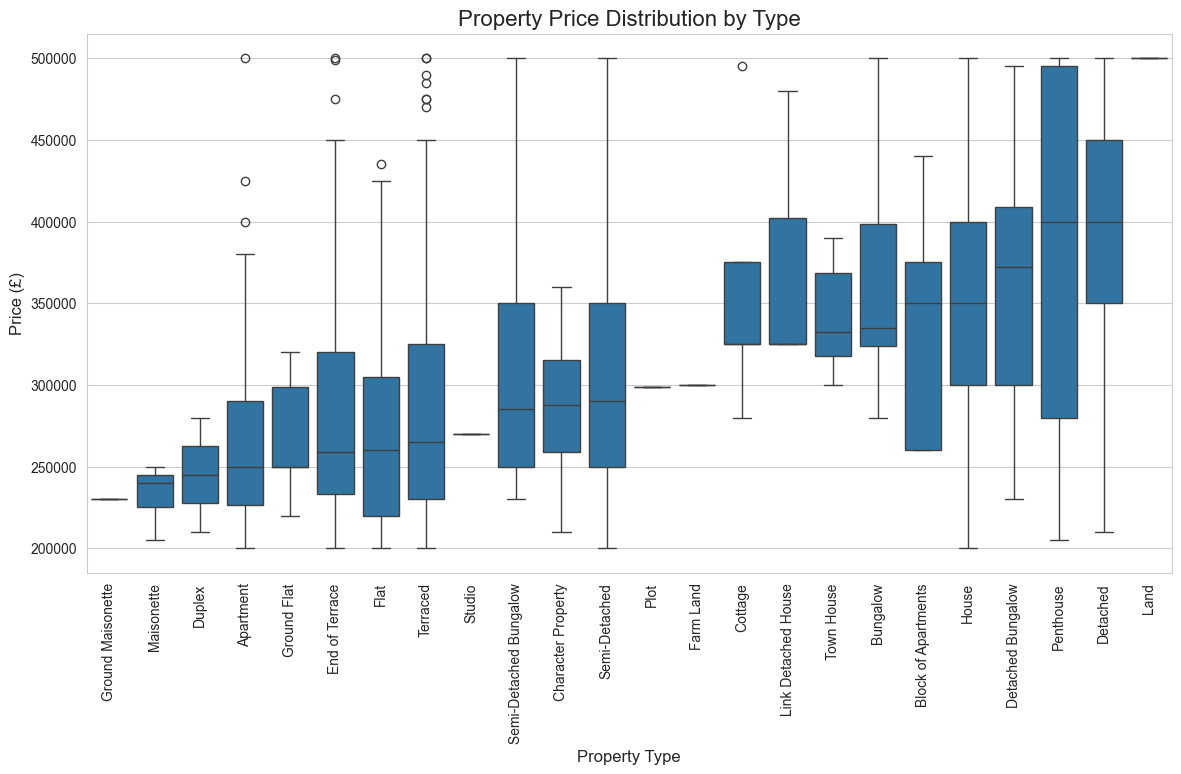

In [8]:
# --- Visualize Price by Property Type ---
sns.set_style('whitegrid')
plt.figure(figsize=(14, 7))
# A boxplot is perfect for comparing distributions across categories
sns.boxplot(data=df_cleaned, x='property_type', y='price', order=df_cleaned.groupby('property_type')['price'].median().sort_values().index)
plt.title('Property Price Distribution by Type', fontsize=16)
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Price (£)', fontsize=12)
plt.xticks(rotation=90)
plt.show()


Generating geospatial price map...


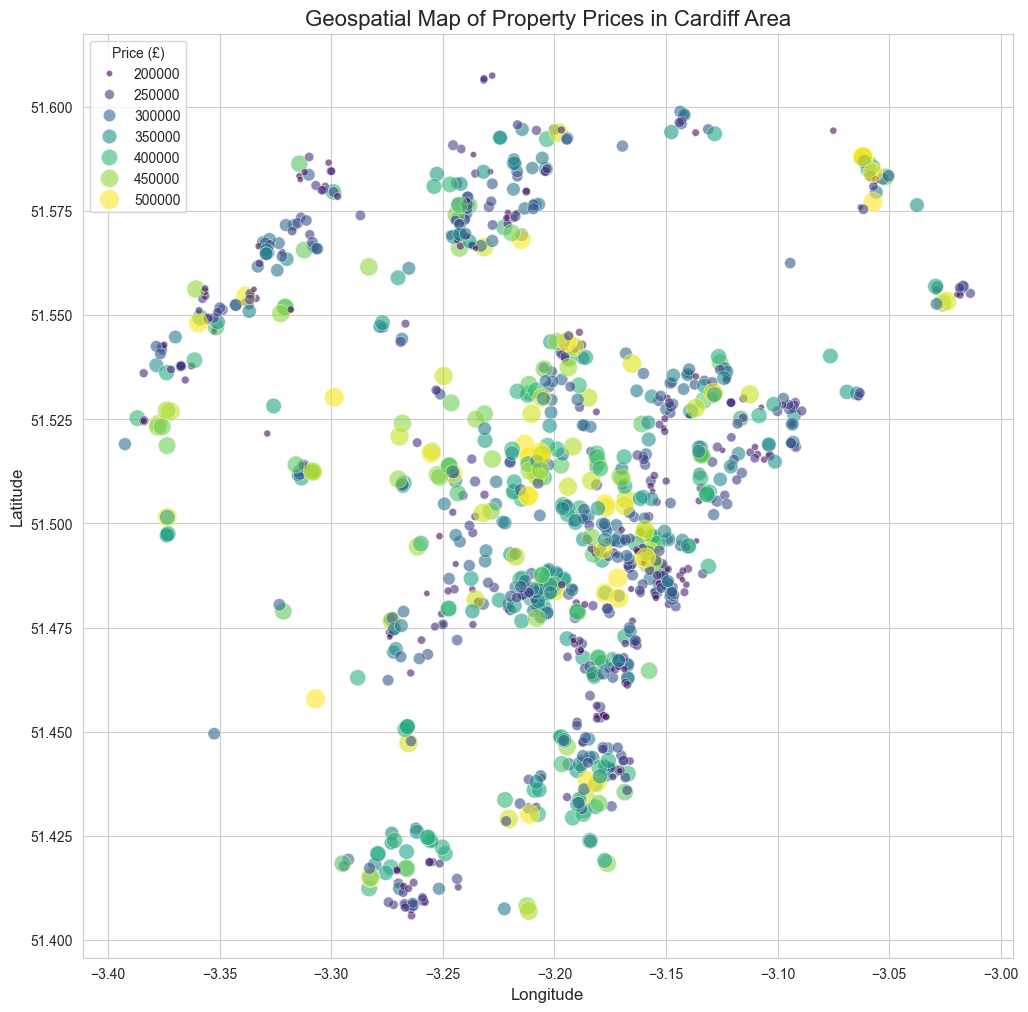

In [9]:
# --- Create a Geospatial Price Map of Cardiff ---
print("\nGenerating geospatial price map...")
plt.figure(figsize=(12, 12))
# A scatterplot using longitude and latitude creates a map
# The 'hue' parameter colors each point based on its price, revealing hotspots
sns.scatterplot(data=df_cleaned, x='longitude', y='latitude', hue='price', palette='viridis', size='price', sizes=(20, 200), alpha=0.6)
plt.title('Geospatial Map of Property Prices in Cardiff Area', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Price (£)')
plt.show()

In [10]:
# --- The above graph is not very readable so lets create an Interactive Geospatial Map with Folium ---

print("Generating interactive price map...")

# Create a base map, centered on Cardiff
# The location is [latitude, longitude] and zoom_start controls the initial zoom level
cardiff_map = folium.Map(location=[51.4816, -3.1791], zoom_start=13)

# Create a HeatMap layer
# This is my favourite way to visualize density and price intensity
# We create a list of points where each point is [latitude, longitude, price]
heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in df_cleaned.iterrows()]

# Add the HeatMap layer to our base map
HeatMap(heat_data, radius=15).add_to(cardiff_map)

# Add individual markers for the top 10 most expensive properties
# Sorting the dataframe by price and taking the top 10
top_10_expensive = df_cleaned.sort_values(by='price', ascending=False).head(10)

for index, row in top_10_expensive.iterrows():
    # Create a popup text with property info
    popup_text = f"Price: £{row['price']:,}<br>Type: {row['property_type']}"
    # Add a circle marker for each of the top 10 properties
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='white',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=popup_text
    ).add_to(cardiff_map)


Generating interactive price map...


In [11]:
# When you run this cell, the interactive map will appear as the output
cardiff_map

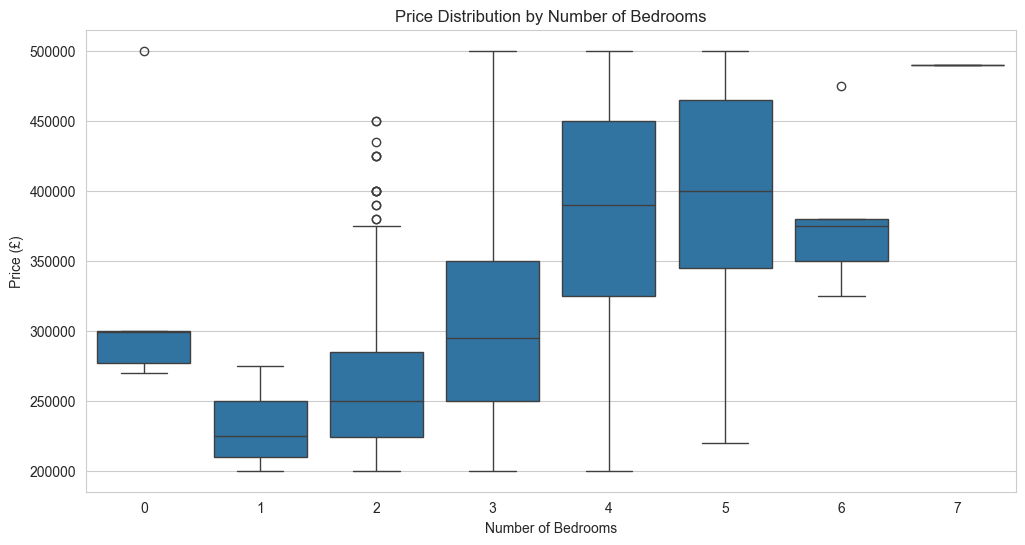

In [12]:
# --- Visualize Price by Number of bedrooms ---

plt.figure(figsize=(12, 6))
sns.boxplot(x='bedrooms', y='price', data=df_cleaned)
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (£)')
plt.show()

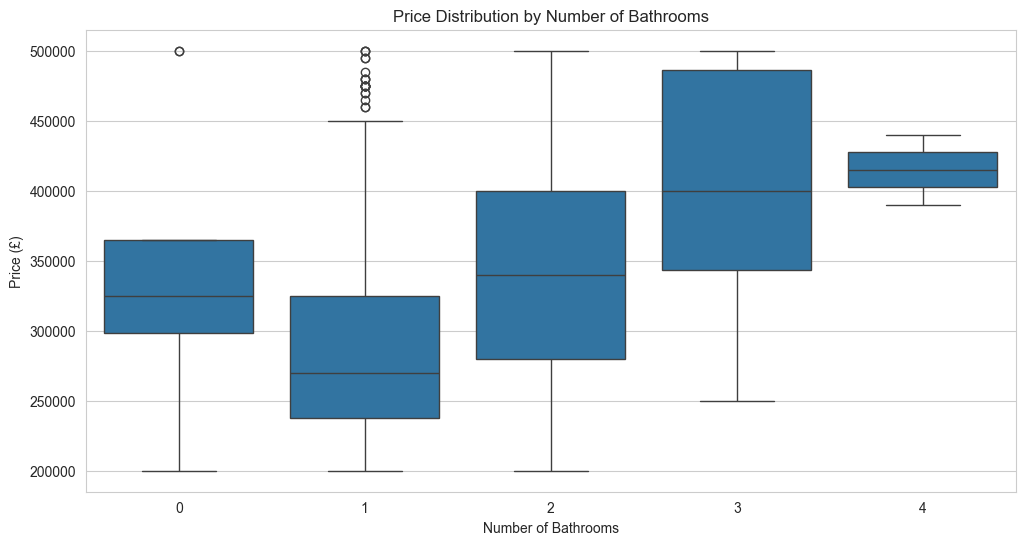

In [13]:
# --- Visualize Price by Number of Bathrooms ---

plt.figure(figsize=(12, 6))
sns.boxplot(x='bathrooms', y='price', data=df_cleaned)
plt.title('Price Distribution by Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price (£)')
plt.show()

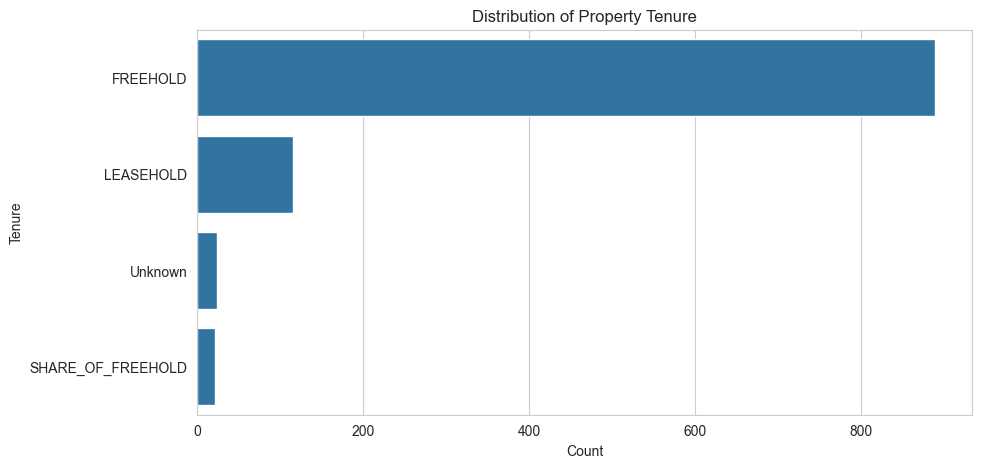

In [14]:
# --- Visualize Distribution of Property Tenure ---

plt.figure(figsize=(10, 5))
sns.countplot(y='tenure', data=df_cleaned, order = df_cleaned['tenure'].value_counts().index)
plt.title('Distribution of Property Tenure')
plt.xlabel('Count')
plt.ylabel('Tenure')
plt.show()


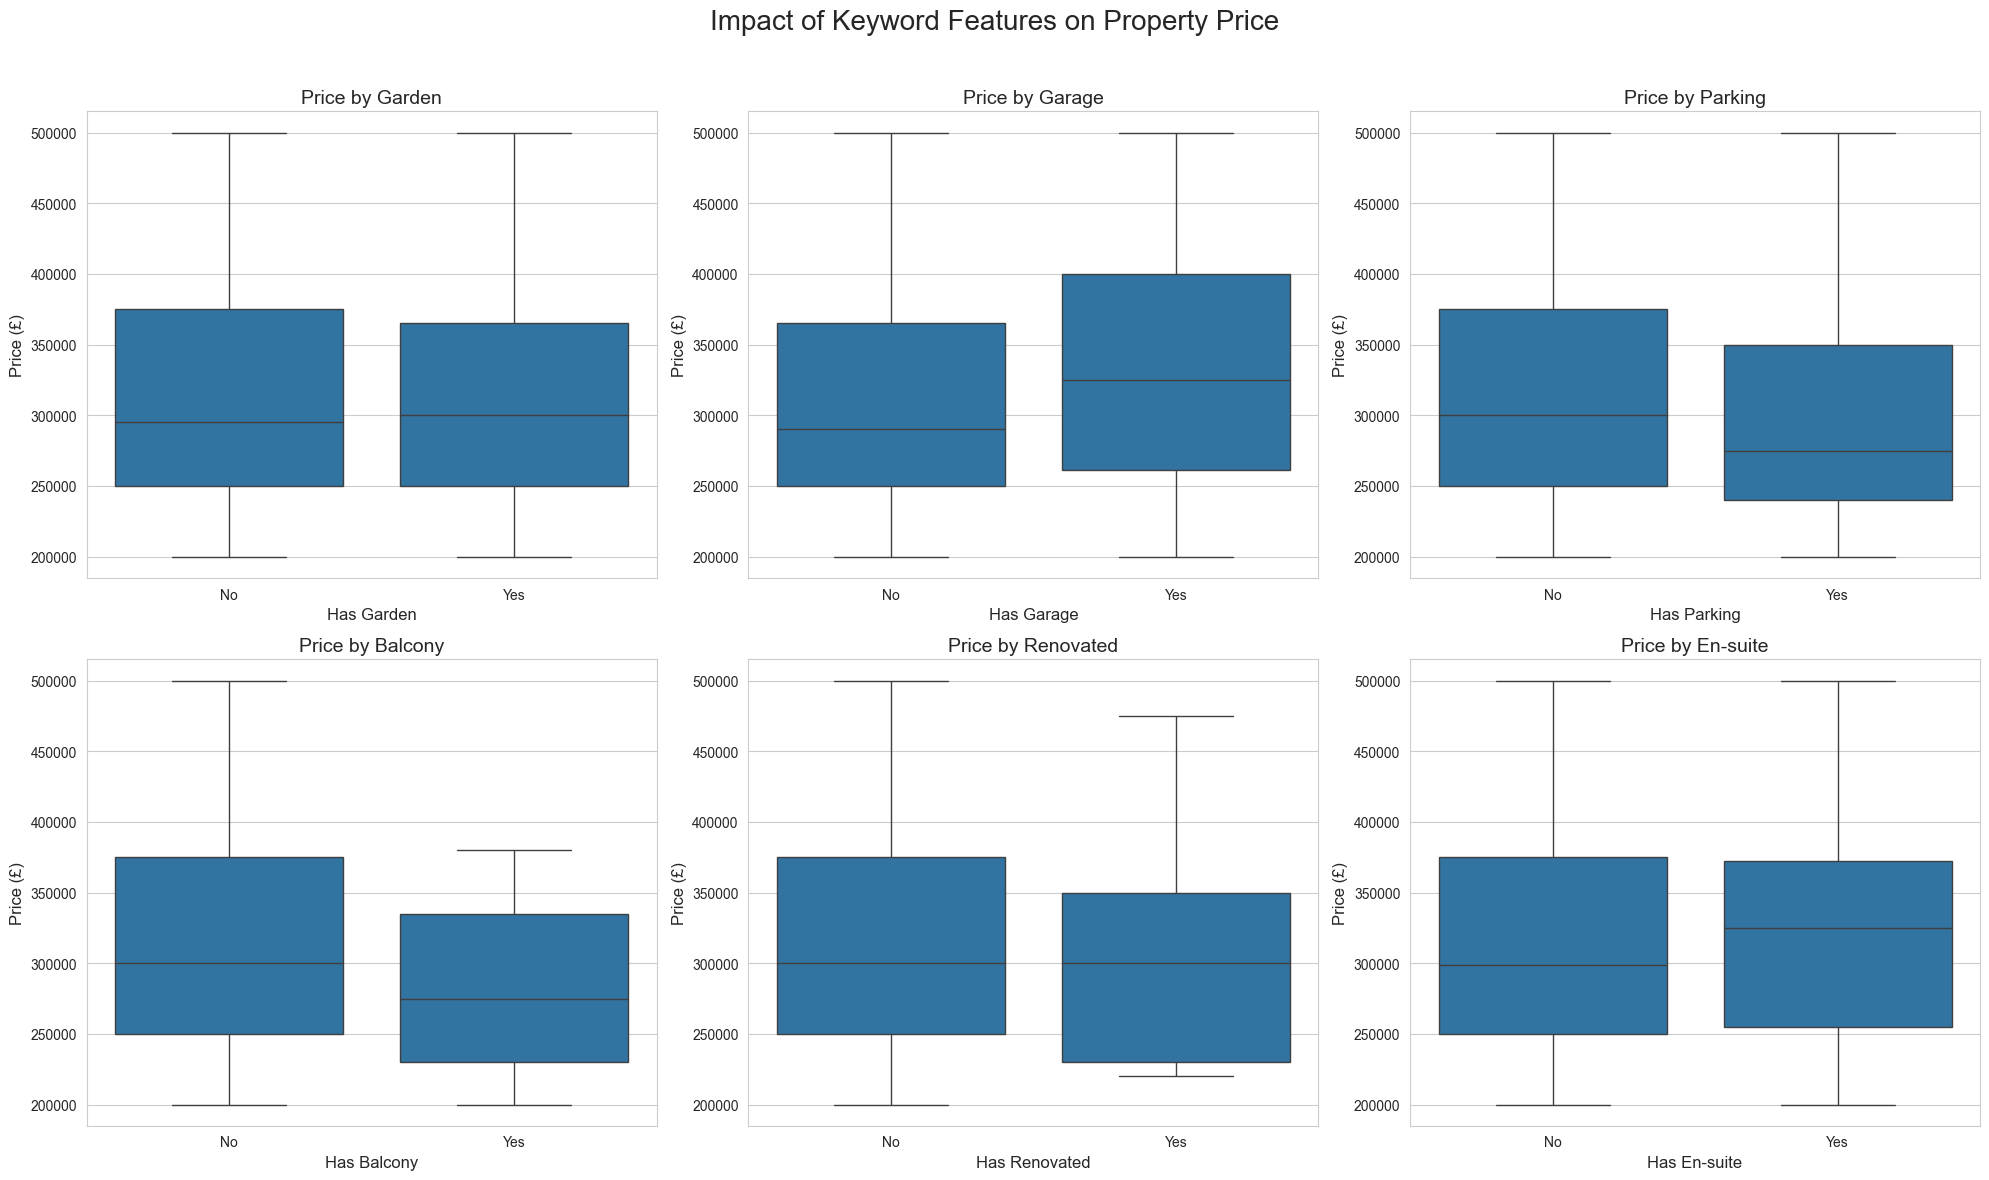

In [15]:

keyword_features = ['has_garden', 'has_garage', 'has_parking', 'has_balcony', 'has_renovated', 'has_en-suite']

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Impact of Keyword Features on Property Price', fontsize=20)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(keyword_features):
    sns.boxplot(ax=axes[i], x=feature, y='price', data=df_cleaned)
    axes[i].set_title(f'Price by {feature.replace("has_", "").capitalize()}', fontsize=14)
    axes[i].set_xlabel(f'Has {feature.replace("has_", "").capitalize()}', fontsize=12)
    axes[i].set_ylabel('Price (£)', fontsize=12)

    axes[i].set_xticks([0, 1]) 
    axes[i].set_xticklabels(['No', 'Yes'])

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

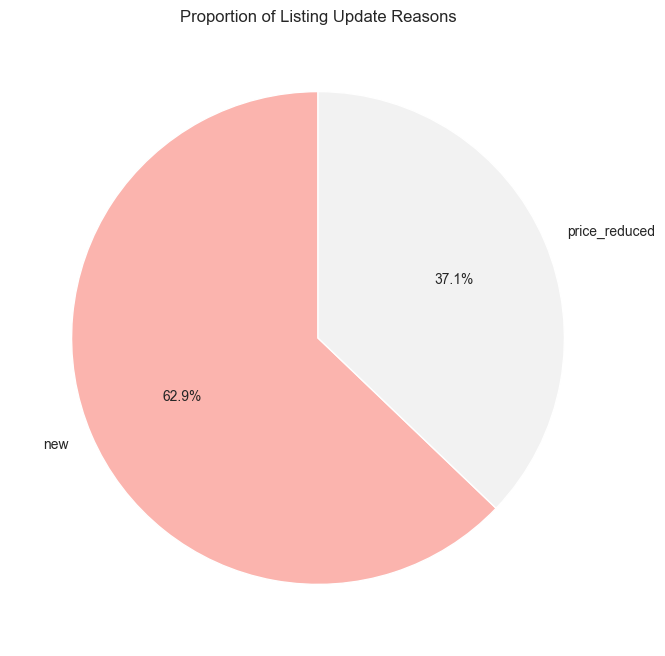

In [16]:
# --- Visualize Proportion of Listing Update Reasons ---

plt.figure(figsize=(10, 8))
df_cleaned['listing_update_reason'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title('Proportion of Listing Update Reasons')
plt.ylabel('')  # Hide the y-label
plt.show()

In [17]:
# --- Prepare for Modelling with One-Hot Encoding ---
# Convert all our text-based features into numerical columns for the model
df_model_ready = pd.get_dummies(df_cleaned, columns=['property_type', 'tenure'], drop_first=True)


In [18]:
# --- Select Features (X) and Target (y) ---
# X will contain all the features we want our model to learn from
# We drop the price (target) and any non-predictive or text-based columns
X = df_model_ready.drop(['price', 'url', 'summary', 'listing_update_reason'], axis=1)

# y is the single column we want our model to predict
y = df_model_ready['price']

In [19]:
# --- Split Data into Training and Testing Sets ---

# This splits the data: 80% for training the model, 20% for testing it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- Data Preparation Complete ---")
print(f"Features (X) shape: {X.shape}")
print(f"Training data (X_train) shape: {X_train.shape}")
print(f"Testing data (X_test) shape: {X_test.shape}")

--- Data Preparation Complete ---
Features (X) shape: (1050, 36)
Training data (X_train) shape: (840, 36)
Testing data (X_test) shape: (210, 36)


In [20]:
# --- Linear Regression Model ---

print("--- Training Linear Regression Model ---")

# Initialize the model
lr_model = LinearRegression()

# Train the model using your training data
lr_model.fit(X_train, y_train)

# Use the trained model to make predictions on the unseen test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate how well the model performed
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Absolute Error: £{mae_lr:,.2f}")
print(f"Linear Regression - R-squared: {r2_lr:.2f}")

--- Training Linear Regression Model ---
Linear Regression - Mean Absolute Error: £51,264.98
Linear Regression - R-squared: 0.38


In [21]:
# --- XGBoost Model ---

print("--- Training XGBoost Model ---")
# Initialize a more powerful XGBoost model
# random_state=42 ensures you get the same results every time
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the same training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model's performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Mean Absolute Error: £{mae_xgb:,.2f}")
print(f"XGBoost - R-squared: {r2_xgb:.2f}")

--- Training XGBoost Model ---
XGBoost - Mean Absolute Error: £40,832.03
XGBoost - R-squared: 0.58


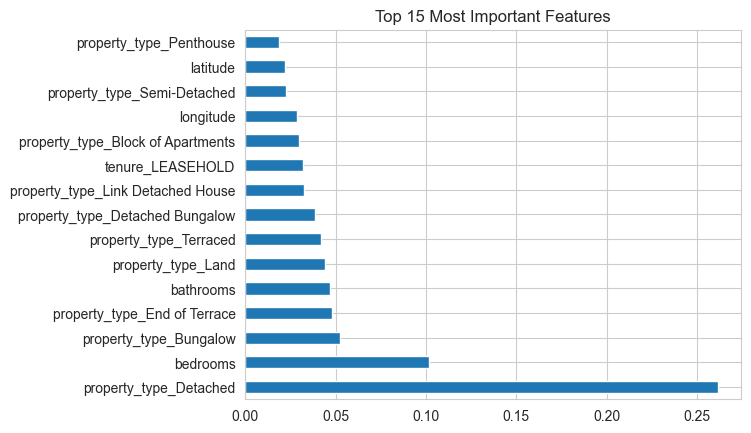

In [22]:
# Create a bar plot of feature importances
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
# Plot top 15 features
feat_importances.nlargest(15).plot(kind='barh') 
plt.title("Top 15 Most Important Features")
plt.show()

In [23]:
print("--- Tuning XGBoost Model ---")

# Define the parameter grid to search
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': randint(3, 10),
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
# n_iter controls how many different combinations to try
# cv=5 means 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Fit the model to find the best parameters
random_search.fit(X_train, y_train)

# Print the best parameters found
print("\n--- Best Parameters Found ---")
print(random_search.best_params_)

--- Tuning XGBoost Model ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Best Parameters Found ---
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 673, 'subsample': 0.7}


In [24]:
print("\n--- Evaluating Tuned Model ---")

# Get the best model from the random search
best_xgb_model = random_search.best_estimator_

# Make predictions on the test data
y_pred_xgb_tuned = best_xgb_model.predict(X_test)

# Evaluate the tuned model's performance
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)

# Print the results for comparison
print(f"\nOriginal XGBoost - Mean Absolute Error: £{mae_xgb:,.2f}")
print(f"Original XGBoost - R-squared: {r2_xgb:.2f}")

print(f"\nTuned XGBoost - Mean Absolute Error: £{mae_xgb_tuned:,.2f}")
print(f"Tuned XGBoost - R-squared: {r2_xgb_tuned:.2f}")


--- Evaluating Tuned Model ---

Original XGBoost - Mean Absolute Error: £40,832.03
Original XGBoost - R-squared: 0.58

Tuned XGBoost - Mean Absolute Error: £38,110.80
Tuned XGBoost - R-squared: 0.62



--- Analyzing Feature Importance ---


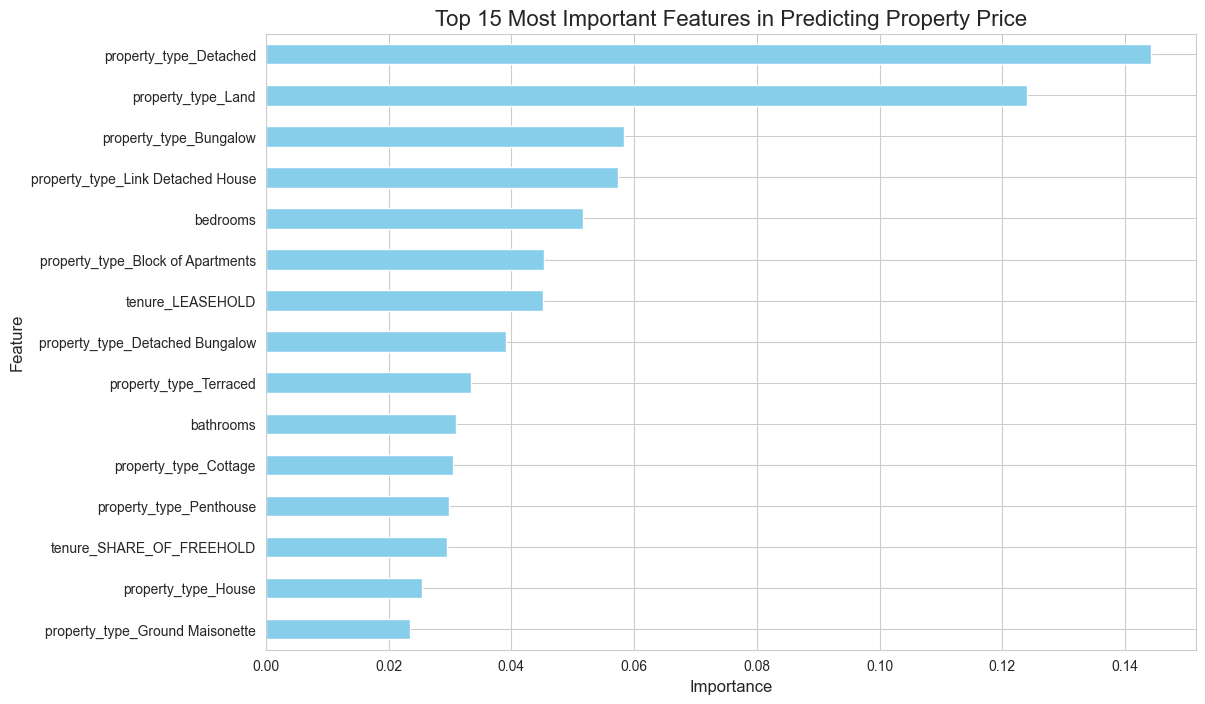

In [25]:
print("\n--- Analyzing Feature Importance ---")

# Get feature importances from the best model
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns)

# Plot the top 15 most important features
plt.figure(figsize=(12, 8))
feature_importances.nlargest(15).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 15 Most Important Features in Predicting Property Price', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


--- Analyzing Feature Importance (Excluding Property Type & Tenure) ---


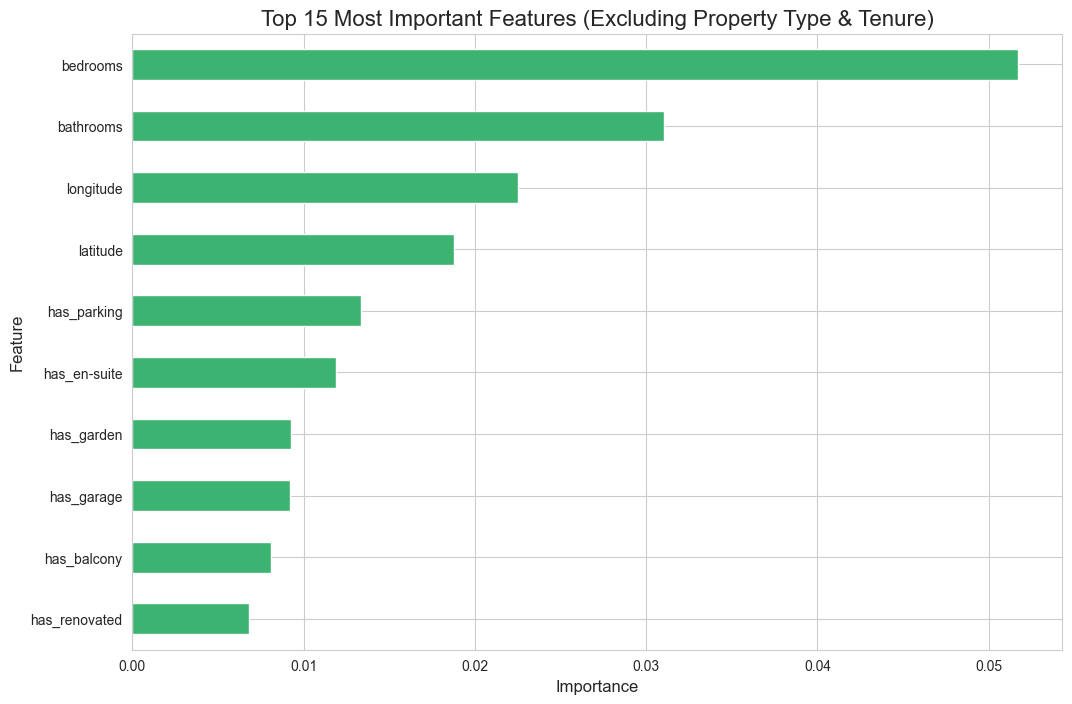

In [26]:
print("\n--- Analyzing Feature Importance (Excluding Property Type & Tenure) ---")

# Get feature importances from the best model
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns)

# Filter out the one-hot encoded 'property_type' & 'tenure' features
feature_importances_filtered = feature_importances[~feature_importances.index.str.startswith('property_type_')]
feature_importances_filtered = feature_importances_filtered[~feature_importances_filtered.index.str.startswith('tenure_')]

# Plot the top 15 most important of the remaining features
plt.figure(figsize=(12, 8))
feature_importances_filtered.nlargest(15).sort_values().plot(kind='barh', color='mediumseagreen')
plt.title('Top 15 Most Important Features (Excluding Property Type & Tenure)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [ ]:
# --- Deployment ---
# Saving the trained XGBoost model to a file
joblib.dump(best_xgb_model, 'property_price_predictor.pkl')

# Saving the list of feature columns the model was trained on
joblib.dump(list(X_train.columns), 'model_columns.pkl')

print("Model and columns have been saved successfully!")

Model and columns have been saved successfully!
